Carlos Bravo Garrán - 100474964

 # __Exploratory Data Analysis (EDA)__ 

 In this notebook, a simplified Exploratory Data Analysis (EDA) will be performed on the provided dataset, with the objective of analyzing and understanding the factors that influence employee attrition in an organization.

### 1. __Load Libraries and Data__


In [169]:
# Data analysis and wrangling
import numpy as np
import pandas as pd
import time

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, roc_curve, auc, confusion_matrix, classification_report)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline




# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

Create virtual environment and install dependencies

In [170]:
# Install venv and requirements
# !python3 -m venv venv
# !source venv/bin/activate
# %pip install -r ../requirements.txt

Load the dataset from the CSV file


In [171]:
df = pd.read_csv("../data/attrition_availabledata_03.csv")

### 2. __Initial Exploration__

Review the general structure of the dataset


In [172]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2925 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2919 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

In [173]:
dataset_shape = df.shape
print(f"The dataset contains {dataset_shape[0]} rows and {dataset_shape[1]} columns.")

The dataset contains 2940 rows and 31 columns.


In [174]:
df.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,2940.000000,2940.000000,2940.000000,2940.000000,2925.000000,2928.000000,2919.000000,2940.000000,2940.000000,2940.000000,...,2940.000000,2927.000000,2940.000000,2940.0,2940.000000,2934.000000,2940.000000,2940.000000,2940.000000,2940.000000
mean,7.326447,12.701701,2.740476,3.160884,2.726496,2.715847,2.756423,36.782653,9.287755,2.902721,...,65115.350340,2.664161,15.260544,8.0,0.789796,11.262440,2.812925,6.988095,2.192517,4.127891
std,1.334478,5.518054,0.718440,0.367487,1.093007,1.099055,0.717885,9.157614,8.157695,1.030032,...,47196.796005,2.495031,3.706960,0.0,0.843302,7.787843,1.287138,5.994740,3.220122,3.540747
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.285664,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,...,28860.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.029037,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,35.000000,7.000000,3.000000,...,48980.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.907145,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,...,83920.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,...,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


In [175]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.466932,14,3,4,3.0,3.0,3.0,34,Non-Travel,Research & Development,...,Y,20,8,1,6.0,3,3,1,2,No
1,6.976151,19,3,3,3.0,1.0,3.0,28,Travel_Rarely,Sales,...,Y,15,8,0,3.0,6,3,1,2,No
2,6.076227,13,2,3,4.0,3.0,3.0,24,Travel_Rarely,Sales,...,Y,12,8,0,1.0,2,1,0,0,Yes
3,7.426888,5,2,3,3.0,2.0,3.0,38,Travel_Rarely,Research & Development,...,Y,19,8,1,7.0,3,5,1,4,Yes
4,5.783249,14,2,3,3.0,4.0,3.0,26,Travel_Rarely,Sales,...,Y,12,8,0,5.0,2,5,1,2,No


In [176]:
df[['Attrition']].head()

,Attrition
0,No
1,No
2,Yes
3,Yes
4,No


This is a __classification__ problem, as the target variable (Attrition) is binary (Yes / No). This means that the model must predict whether an employee will leave the company or not, rather than predicting a numerical value.

### 3. __Identify Categorical and Numerical Variables__

In [177]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
print("Categorical variables:", categorical_columns)
print("Numerical variables:", numerical_columns)

Categorical variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Numerical variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


#### 3.1 Reclassify variables by adding ordinals

In [178]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
ordinal_columns = ["Education", "JobLevel", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "PerformanceRating", "StockOptionLevel"]
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# Remove from numerical the ones we have classified as ordinal
numerical_columns = [col for col in numerical_columns if col not in ordinal_columns]

print("Categorical variables:", categorical_columns)
print("Ordinal variables:", ordinal_columns)
print("Numerical variables:", numerical_columns)


Categorical variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Ordinal variables: ['Education', 'JobLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating', 'StockOptionLevel']
Numerical variables: ['hrs', 'absences', 'JobInvolvement', 'Age', 'DistanceFromHome', 'EmployeeCount', 'EmployeeID', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


#### 3.2 Detect high cardinality categorical variables

Identify categorical variables that may generate too many columns when encoding them


In [179]:
categorical_cardinality = df[categorical_columns].nunique().sort_values(ascending=False)
display(categorical_cardinality)


JobRole           9
EducationField    6
Department        3
BusinessTravel    3
MaritalStatus     3
Gender            2
Attrition         2
Over18            1
dtype: int64

It is not considered that there are high cardinality categorical variables, therefore no additional grouping or different encoding will be needed.

### 4. __Analysis of the Target Variable__

Review the distribution of the target variable to identify class imbalance

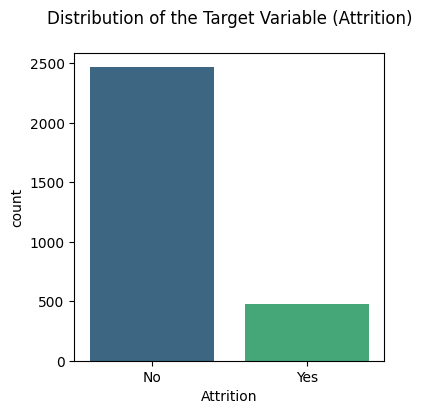

,proportion
0,83.877551
1,16.122449


In [180]:
if "Attrition" in df.columns:
    plt.figure(figsize=(4,4))
    sns.countplot(x=df["Attrition"], palette="viridis")
    plt.title("Distribution of the Target Variable (Attrition)\n")
    plt.show()
    
    attrition_counts = df["Attrition"].value_counts(normalize=True)
    display(pd.DataFrame(attrition_counts).rename(columns={"Attrition": "Proportion"}).reset_index(drop=True)*100)


In [181]:
df.Attrition.value_counts().sort_index().to_frame()

,count
Attrition,
No,2466
Yes,474


The dataset is imbalanced, with 2466 employees not leaving the company (NO) and 474 who do leave (YES).

This means that the majority of employees do not leave the company, which could cause a poorly trained model to always predict "No", achieving an apparently high accuracy, but without actually capturing the cases of attrition.


### 5. __Identify Missing Values__

In [182]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].to_frame().reset_index()
missing_values.columns = ["Column Name", "Missing Values"]

display(missing_values)

,Column Name,Missing Values
0,EnvironmentSatisfaction,15
1,JobSatisfaction,12
2,WorkLifeBalance,21
3,NumCompaniesWorked,13
4,TotalWorkingYears,6


Since the missing values are very few compared to the total number of data, we will take the following measures:
- Impute missing values in numerical variables with the median
- Impute missing values in categorical variables with the mode

In [183]:
# Columns differentiated by type
num_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in ordinal_columns]
ord_cols = ordinal_columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

### 6. __Identify Constant and Identifying Variables__

#### 6.1 Check for columns with unique values

In [184]:
unique_values = df.nunique()

constant_columns = df.nunique()[df.nunique() == 1].to_frame().reset_index()
constant_columns.columns = ["Column Name", "Unique Value Count"]
constant_columns["Unique Value"] = constant_columns["Column Name"].apply(lambda col: df[col].unique()[0])
constant_columns_list = constant_columns["Column Name"].tolist()

display(constant_columns)

,Column Name,Unique Value Count,Unique Value
0,EmployeeCount,1,1
1,Over18,1,Y
2,StandardHours,1,8


#### 6.2 Check for columns with ID variables

In [185]:
print(f"Total number of rows: {len(df)}")

unique_values = df.nunique()
print("Number of unique values per column:")
print(unique_values, "\n")

id_columns = [col for col in df.columns if df[col].nunique() == len(df)]
print("Identifying columns detected:", id_columns)

Total number of rows: 2940
Number of unique values per column:
hrs                        2939
absences                     24
JobInvolvement                4
PerformanceRating             2
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
Age                          43
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 2940
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1304
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWith

As its name indicates, _EmployeeID_ is an identifying variable, making it redundant for the study.

On the other hand, the _hours_ column has 2939 values, 1 less than the total number of rows. It might be considered identifying, but upon checking the values, we see that they are simply different decimal values.

#### 6.3 Remove Constant and Identifying Columns

In [186]:
df = df.drop(columns=constant_columns_list + id_columns, errors='ignore')
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

print('The following columns have been removed:', constant_columns_list + id_columns)


The following columns have been removed: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']


### 7. __Create Correlation Matrix__

Generate the correlation matrix to understand relationships between numerical variables, having already removed constant and identifying variables.

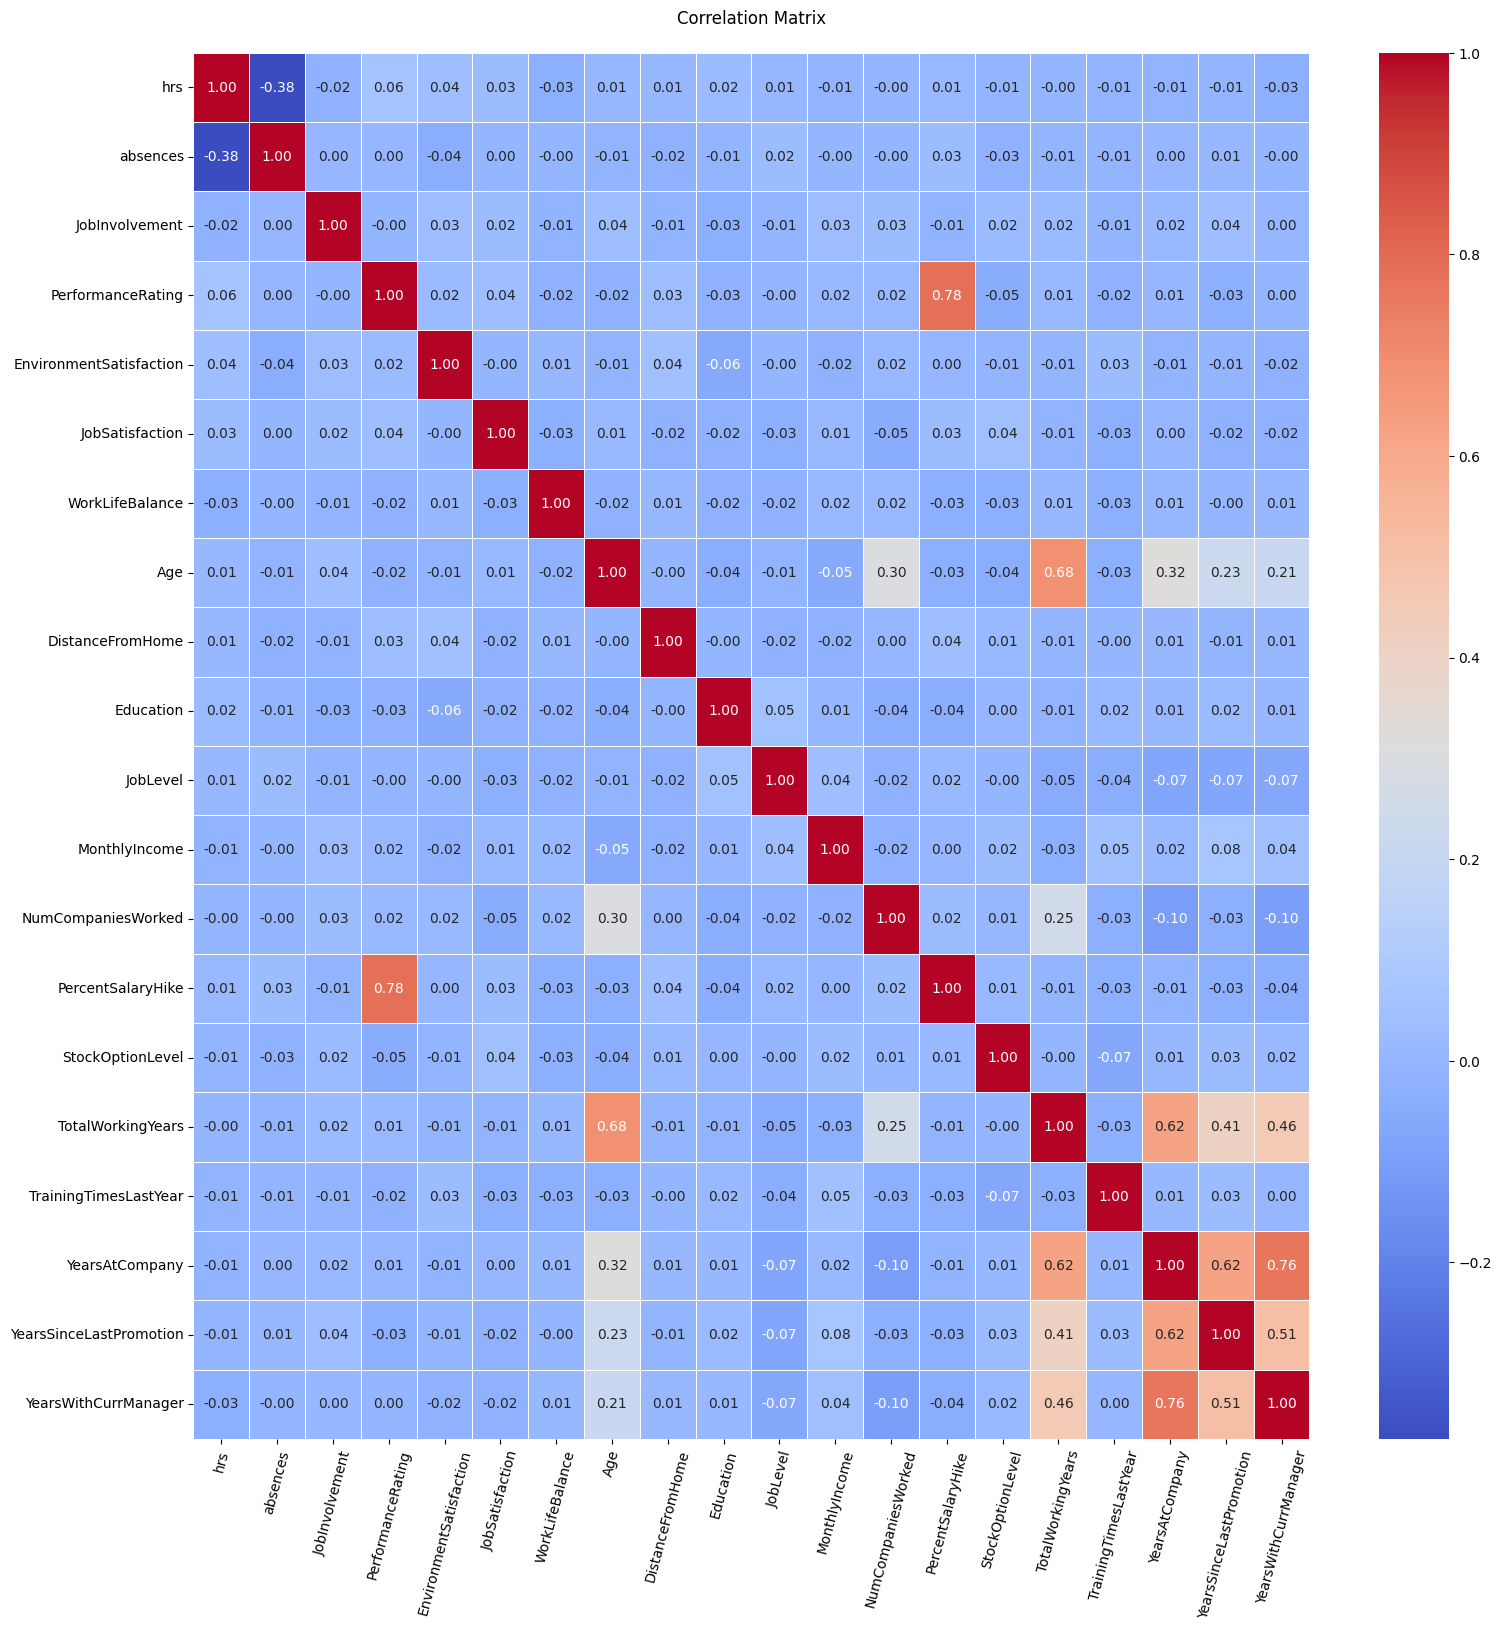

In [187]:
df_numeric = df.select_dtypes(include=['number'])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm")
plt.xticks(rotation=75)
plt.title("Correlation Matrix\n")
plt.show()


There are no extremely high correlations, close to 1 or -1, so the variables are not redundant nor strongly dependent on each other. However, there are some moderate correlations that we can consider.

__Relationship between tenure and work experience:__

- _YearsAtCompany_ and _YearsWithCurrManager_ (0.76): Employees who have been with the company longer are more likely to have been with the same manager for a longer time.
- _YearsAtCompany_ and _TotalWorkingYears_ (0.62): The longer a person has worked in general, the more time they may have spent at the current company.

__Relationship between _PercentSalaryHike_ and _PerformanceRating_ (0.78):__ There is a high correlation between salary increase and performance rating. Employees with better performance receive higher salary increases.

- It could be evaluated if _PercentSalaryHike_ is redundant, as it is strongly linked to _PerformanceRating_.


Regarding the rest, they have very low correlations with all the others, indicating that they may be independent or influenced by other factors not considered. Thus, it could be reviewed if these variables have any significant impact on the target variable, or if they can be eliminated.


### 8. __Identify Correlation with the Target Variable__

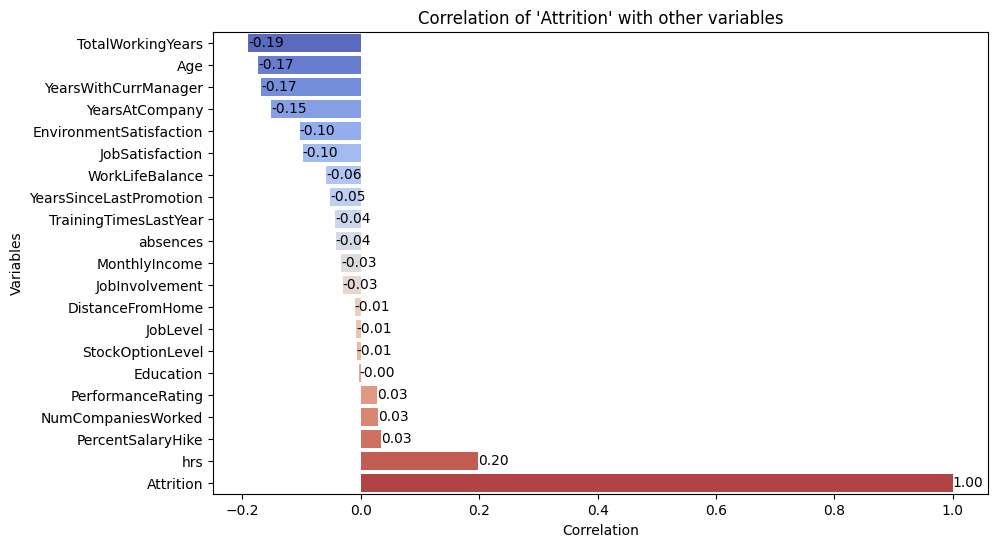

In [188]:
# Convert the target variable to numeric
df_aux = df.copy()
df_aux["Attrition"] = df_aux["Attrition"].map({"Yes": 1, "No": 0})

# Ensure we only work with numeric columns
df_corr = df_aux.select_dtypes(include=['number'])
attrition_correlation = df_corr.corr()["Attrition"].sort_values()

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=attrition_correlation.index, x=attrition_correlation.values, palette="coolwarm")

# Add values on the bars
for index, value in enumerate(attrition_correlation.values):
    ax.text(value, index, f"{value:.2f}", ha="left", va="center", fontsize=10, color="black")

plt.title("Correlation of 'Attrition' with other variables")
plt.xlabel("Correlation")
plt.ylabel("Variables")
plt.show()


Se puede comprobar que no hay una variable con una correlación extremadamente fuerte con Attrition, pero sí que muchas de ellas tienen una relación muy baja, por ello cabría la posibilidad de considerar su elimiación con el fin de simplificar el modelo.

Junto con las horas trabajadas, las variables de antigüedad (_YearsAtCompany_, _TotalWorkingYears_) son las que más influyen en la retención, se pueden evaluar las relaciones con _YearsWithCurrManager_ para comprobar si esta última sería redundante.

- Se podrían eliminar las variables que tienen muy baja correlación con la objetivo.

In [189]:
# Filter variables with correlation less than 0.05 in absolute value
low_corr_columns = attrition_correlation[abs(attrition_correlation) < 0.05].index.tolist()

# Remove these columns from the dataset
df_filtered = df.drop(columns=low_corr_columns, errors='ignore')

print(f"The following columns have been removed in a test dataframe due to low correlation: {low_corr_columns}")


The following columns have been removed in a test dataframe due to low correlation: ['TrainingTimesLastYear', 'absences', 'MonthlyIncome', 'JobInvolvement', 'DistanceFromHome', 'JobLevel', 'StockOptionLevel', 'Education', 'PerformanceRating', 'NumCompaniesWorked', 'PercentSalaryHike']


### __9. Visualize Relationships Between Correlated Variables__
Perform a visual exploration of the relationships between highly correlated variables to help decide if there are redundancies or if some variables need to be transformed before using them in a predictive model.

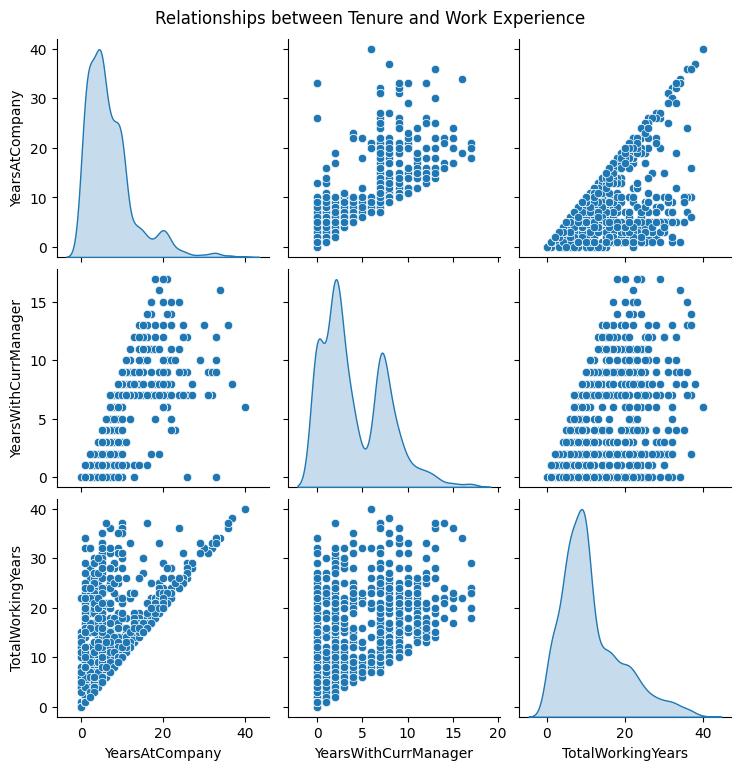

In [190]:
# Visualize relationships between tenure variables with pairplot
sns.pairplot(df, vars=["YearsAtCompany", "YearsWithCurrManager", "TotalWorkingYears"], diag_kind="kde")
plt.suptitle("Relationships between Tenure and Work Experience", y=1.02)
plt.show()


__Relationship between Tenure and Work Experience__

- _YearsAtCompany_ and _YearsWithCurrManager_ (0.76): Strong relationship, possible redundancy.
- _YearsAtCompany_ and _TotalWorkingYears_ (0.62): Expected relationship, but provides different information.
- Conclusion: _YearsAtCompany_ or _YearsWithCurrManager_ could be redundant.

It could be evaluated for impact on the model and one could be removed if necessary.


Having identified and evaluated the variables, checking for null values, constant and identifying values, and correlations between them, we can proceed to the evaluation of potential classification models.

## __Evaluation of Classification Models with Advanced Preprocessing__
In this section, a preprocessing and modeling pipeline is implemented to predict the Attrition variable in an employee dataset. Cross-validation will be used for internal evaluation (inner evaluation) and a final evaluation with an independent test set (outer evaluation).

The main steps followed are:

1. Splitting data into training and test sets (2/3 for training the model - 1/3 for evaluating final performance).
2. Data preprocessing, including imputation, scaling, encoding, and dimensionality reduction.
3. Internal evaluation (inner evaluation) using stratified cross-validation.
4. Training and final evaluation (outer evaluation) with key metrics such as balanced accuracy, accuracy, TPR, TNR, and confusion matrix.

### __1. Data Splitting into Train and Test__

The predictor variables (X) are separated from the target variable (y) and the data is split into training and test sets.Se separan las variables predictoras (X) de la variable objetivo (y) y realiza la división de los datos en conjuntos de entrenamiento y prueba

In [191]:
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1/3, random_state=100474964)

### __2. Data Preprocessing__

The preprocessing steps for each variable type are as follows:

1. **_Ordinal Variables_**:  
    - Applied Label Encoding using _OrdinalEncoder_.
    - Missing values are imputed with the median using _SimpleImputer_.

2. **_Categorical Variables_**:  
    - Missing values are imputed with the most frequent value (_most_frequent_) using _SimpleImputer_.
    - Encoded with _OneHotEncoder_ to handle categorical data.
    - Dimensionality reduction is applied using _PCA_ with _n_components=5_.

3. **_Numerical Variables_**:  
    - Missing values are imputed with the median using _SimpleImputer_.
    - Scaled using _RobustScaler_ to handle outliers effectively.

A _ColumnTransformer_ is used to combine these preprocessing steps into a single pipeline for efficient application to the dataset.


#### 2.1 Identification of Variable Types


In [192]:
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
ordinal_columns = ["Education", "JobLevel", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "PerformanceRating", "StockOptionLevel"]


#### 2.2 Comparison Between Means and Medians


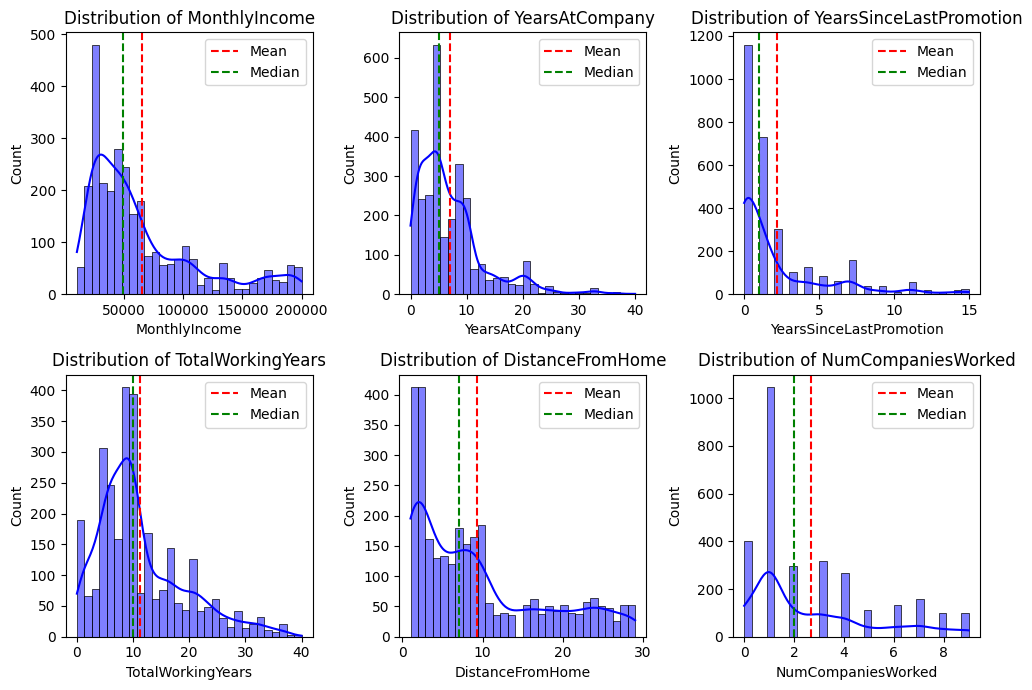

In [237]:
# Select columns with significant differences between mean and median
selected_columns = [
    "MonthlyIncome", "YearsAtCompany", "YearsSinceLastPromotion",
    "TotalWorkingYears", "DistanceFromHome", "NumCompaniesWorked"
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    sns.histplot(df[col], kde=True, bins=30, color='blue', ax=axes[i]) 
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes[i].axvline(df[col].median(), color='green', linestyle='--', label='Median')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

1. **Significant Differences Between Mean and Median**: Variables such as _MonthlyIncome_, _YearsAtCompany_, and _YearsSinceLastPromotion_ show notable differences between their means and medians, indicating skewed distributions or outliers.  
2. **Skewed Distributions**: Positive skew in variables like _MonthlyIncome_ and _YearsAtCompany_ suggests that means are influenced by extreme values, while medians are more robust.  
3. **Robustness of the Median**: In skewed distributions, the median is less sensitive to outliers, making it more suitable for describing the center of the data and imputing missing values.  

Given that many variables show significant differences between mean and median, along with skewed distributions, it is concluded that the __median__ is a more robust and representative strategy for imputing missing data.


##### 2.3 Justification for SimpleImputer

During the process of imputing missing values, the use of **KNNImputer** was tested as an alternative to **SimpleImputer**. However, the results obtained with **KNNImputer** were inferior in terms of model performance. This could be due to the fact that, with very few missing values in the dataset, the use of KNNImputer introduces unnecessary noise by attempting to estimate values based on the nearest neighbors.

For this reason, **SimpleImputer** was chosen, using the median imputation strategy for numerical variables and the mode for categorical variables, as this technique is more robust and suitable for datasets with few missing values.

#### 2.4 Transformations by Variable Type

In [194]:
from sklearn.preprocessing import StandardScaler
# Apply Label Encoding to ordinal variables
df[ordinal_columns] = OrdinalEncoder().fit_transform(df[ordinal_columns])

# Ordinal pipeline
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

# Numerical pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_columns),
    ('cat', cat_transformer, categorical_columns),
    ('ord', ord_transformer, ordinal_columns)
])


preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['hrs', 'absences', 'JobInvolvement',
                                  'PerformanceRating',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'Age', 'DistanceFromHome',
                                  'Education', 'JobLevel', 'MonthlyIncome',
                                  'NumCompaniesWorked', 'PercentSalaryHike',...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 ['BusinessTravel', 'Department',
                                  'EducationField', 'Gender', 'JobRole',
                                  'MaritalStatus']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Education', 'JobLevel',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'PerformanceRating',
                                  'StockOptionLevel'])])

#### 2.5 Model Evaluation with SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique)** has been applied directly in the model definition within the pipeline. This ensures that class balancing is integrated during the model training process, adequately representing the minority classes.

After applying SMOTE, it has been verified that:
- **Classes have been correctly balanced**, reducing bias towards the majority class.
- **Performance metrics have improved**, especially in the True Positive Rate (TPR), indicating that the models are more effective in detecting the minority class.

Additionally, the computational cost of applying SMOTE has been low, making it a viable technique to improve class balance without significantly affecting training and inference efficiency.

### __3. Conversion of Target Variable (Attrition)__
Convert the Attrition variable to a binary format (1 for "Yes" and 0 for "No")

In [195]:
y_train = y_train.map({"Yes": 1, "No": 0})
y_test = y_test.map({"Yes": 1, "No": 0})

### __4. Application of the Preprocessor__
The preprocessor is fitted and transforms the training and test data

In [196]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [197]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates a classification model and displays key metrics, confusion matrix, and ROC curve.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tpr = recall_score(y_test, y_pred)  # Sensitivity / TPR
    tnr = recall_score(y_test, y_pred, pos_label=0)  # Specificity / TNR
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"=== Final Evaluation: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"TPR (Sensitivity): {tpr:.4f}")
    print(f"TNR (Specificity): {tnr:.4f}")
    print("\nConfusion Matrix:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

    if y_prob is not None:
        fpr, tpr_curve, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr_curve)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {auc_score:.4f})', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
        
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend()
        plt.grid()
        plt.show()
    
        return {"Accuracy": acc, "Balanced Accuracy": bal_acc, "TPR": tpr, "TNR": tnr, "AUC": auc_score}
    
    return {"Accuracy": acc, "Balanced Accuracy": bal_acc, "TPR": tpr, "TNR": tnr, "AUC": None}

### __5. Evaluation with Dummy Model__

A Dummy model is trained to establish reference points:

- Expected Balanced Accuracy if the model were trivial.
- Comparison with trained models to demonstrate their effectiveness.

This will verify if the models are truly learning patterns or simply reflecting class distribution.

=== Final Evaluation: Dummy Model ===
Accuracy: 0.8388
Balanced Accuracy: 0.5000
TPR (Sensitivity): 0.0000
TNR (Specificity): 1.0000

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       822
           1       0.00      0.00      0.00       158

    accuracy                           0.84       980
   macro avg       0.42      0.50      0.46       980
weighted avg       0.70      0.84      0.77       980



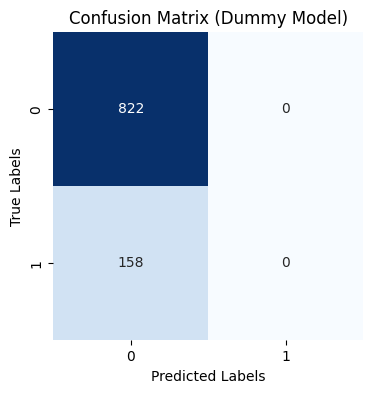

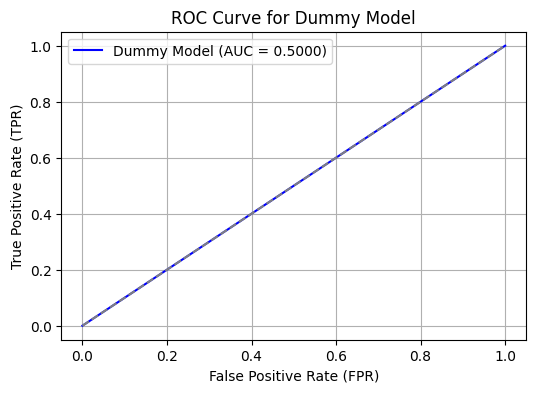

In [198]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_transformed, y_train)
dummy_ev = evaluate_model(dummy, X_test_transformed, y_test, "Dummy Model")


### __6. Definition of Models with Pipeline__
A pipeline is built that includes preprocessing and the classification model (_DecisionTreeClassifier_ and _KNeighborsClassifier_).

In [199]:
clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=100474964)),
    ('classifier', tree.DecisionTreeClassifier(class_weight='balanced'))
])

clf_tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompa...
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Education', 'JobLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating',
                                                   'StockOptionLevel'])])),
                ('smote', SMOTE(random_state=100474964)),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [200]:
clf_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=100474964)),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

clf_knn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompa...
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Education', 'JobLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating',
                                                   'StockOptionLevel'])])),
                ('smote', SMOTE(random_state=100474964)),
                ('classifier', KNeighborsClassifier())])

### __7. Internal Evaluation (Inner Evaluation)__
For internal evaluation, stratified cross-validation (StratifiedKFold) with 5 splits (n_splits=5) is used.

In [201]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100474964)
cross_val_scores = cross_val_score(clf_tree, X_train, y_train, cv=skf, scoring='balanced_accuracy')
print(f"Balanced Accuracy (inner evaluation): {np.mean(cross_val_scores):.4f}")

Balanced Accuracy (inner evaluation): 0.7908


### __8. Model Train__
The model is fitted with the entire training set.

In [202]:
start_time = time.time()
clf_tree.fit(X_train, y_train)
end_time = time.time()
tree_time = end_time - start_time

start_time = time.time()
clf_knn.fit(X_train, y_train)
end_time = time.time()
knn_time = end_time - start_time

### __9. Evaluation with Test (Outer Evaluation)__
Predictions are made on the test set and the main metrics are calculated:

- Balanced Accuracy: Average of TPR and TNR.
- Accuracy: Proportion of correct predictions.
- TPR (Sensitivity/Recall): How well the model detects positive cases.
- TNR (Specificity): How well the model detects negative cases.
- Confusion Matrix: Detailed visualization of hits and errors.

=== Final Evaluation: Decision Tree (Base) ===
Accuracy: 0.9020
Balanced Accuracy: 0.8112
TPR (Sensitivity): 0.6772
TNR (Specificity): 0.9453

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       822
           1       0.70      0.68      0.69       158

    accuracy                           0.90       980
   macro avg       0.82      0.81      0.82       980
weighted avg       0.90      0.90      0.90       980



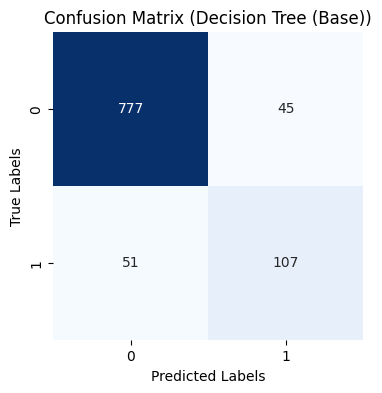

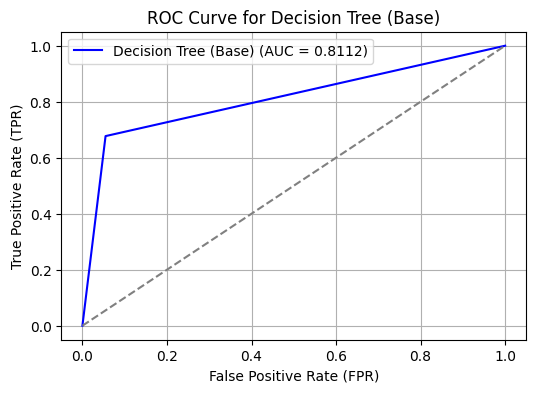

=== Final Evaluation: KNN (Base) ===
Accuracy: 0.7163
Balanced Accuracy: 0.7644
TPR (Sensitivity): 0.8354
TNR (Specificity): 0.6934

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       822
           1       0.34      0.84      0.49       158

    accuracy                           0.72       980
   macro avg       0.65      0.76      0.65       980
weighted avg       0.86      0.72      0.75       980



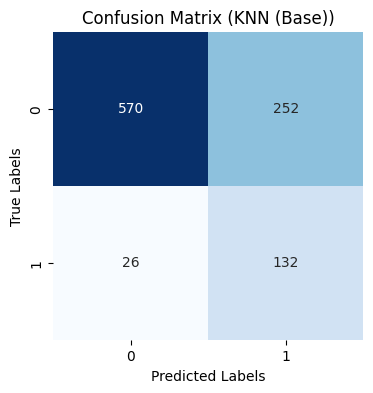

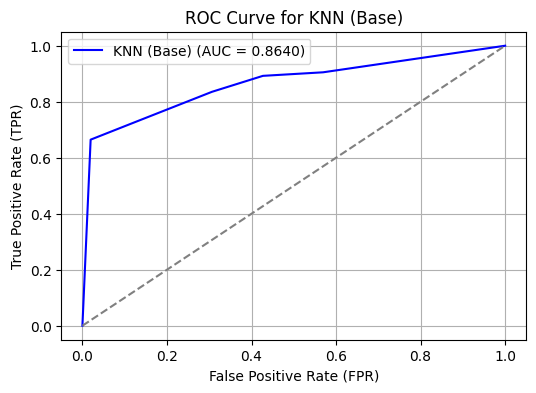

In [203]:
d_tree_ev = evaluate_model(clf_tree, X_test, y_test, "Decision Tree (Base)")
knn_ev = evaluate_model(clf_knn, X_test, y_test, "KNN (Base)")

### __10. Model Optimization with RandomizedSearchCV__

Randomized hyperparameter search (_RandomizedSearchCV_) is used to find the best configuration for the models to improve their performance by efficiently tuning their hyperparameters.

- KNN (_n_neighbors_, _weights_, _metric_).  
- Decision Tree (_max_depth_, _criterion_).


In [204]:
param_dist_knn = {
    "n_neighbors": randint(1, 10), 
    "weights": ["uniform", "distance"], 
    "metric": ["euclidean", "manhattan"]}

param_dist_tree = {
    "max_depth": randint(2, 30),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 3),
    "splitter": ["best"]
}

random_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                                param_distributions=param_dist_knn, 
                                n_iter=20, cv=5, 
                                scoring="balanced_accuracy", 
                                n_jobs=-1, random_state=100474964)

random_tree = RandomizedSearchCV(DecisionTreeClassifier(), 
                                 param_distributions=param_dist_tree, 
                                 n_iter=30, cv=skf, 
                                 scoring="balanced_accuracy", 
                                 n_jobs=-1, random_state=100474964)

start_time = time.time()
random_knn.fit(X_train_transformed, y_train)
end_time = time.time()
knn_hpo_time = end_time - start_time

start_time = time.time()
random_tree.fit(X_train_transformed, y_train)
end_time = time.time()
tree_hpo_time = end_time - start_time

print(f"Best hyperparameters for KNN: {random_knn.best_params_}")
print(f"Balanced Accuracy KNN: {random_knn.best_score_:.4f}")
print(f"Best hyperparameters for Decision Tree: {random_tree.best_params_}")
print(f"Balanced Accuracy Decision Tree: {random_tree.best_score_:.4f}")


Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Balanced Accuracy KNN: 0.8308
Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
Balanced Accuracy Decision Tree: 0.7895


##### Tests of Distances and Their Impact on the Model
Various values for distance metrics (_euclidean_ and _manhattan_) have been tested in the KNN model, along with different hyperparameter configurations (_n_neighbors_ and _weights_), to find the optimal values. 

Now, the impact on the performance of the optimized model will be evaluated.


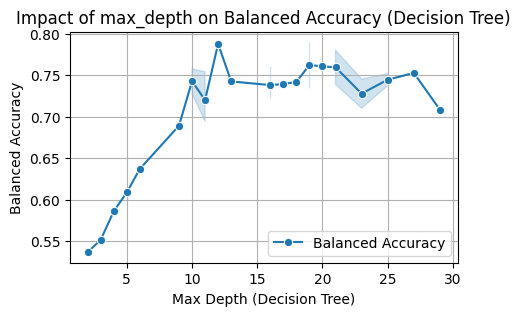

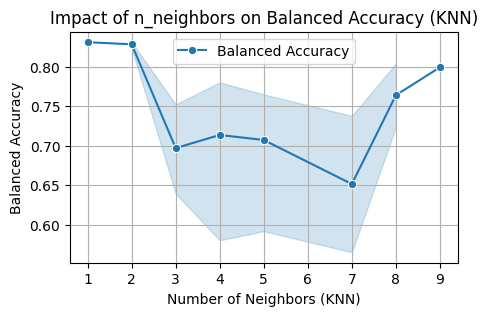

In [205]:
# Extract results from RandomizedSearchCV for Decision Tree
tree_results = pd.DataFrame(random_tree.cv_results_)
plt.figure(figsize=(5, 3))
sns.lineplot(x=tree_results["param_max_depth"], y=tree_results["mean_test_score"], marker="o", label="Balanced Accuracy")
plt.xlabel("Max Depth (Decision Tree)")
plt.ylabel("Balanced Accuracy")
plt.title("Impact of max_depth on Balanced Accuracy (Decision Tree)")
plt.grid()
plt.show()

# Extract results from RandomizedSearchCV for KNN
knn_results = pd.DataFrame(random_knn.cv_results_)
plt.figure(figsize=(5, 3))
sns.lineplot(x=knn_results["param_n_neighbors"], y=knn_results["mean_test_score"], marker="o", label="Balanced Accuracy")
plt.xlabel("Number of Neighbors (KNN)")
plt.ylabel("Balanced Accuracy")
plt.title("Impact of n_neighbors on Balanced Accuracy (KNN)")
plt.grid()
plt.show()


### __11. Evaluation of Optimized Models__

To confirm that hyperparameter optimization actually improves performance:
- The best hyperparameters are selected and the final models are trained.
- All metrics are recalculated to see the improvement over the default models.


=== Final Evaluation: Decision Tree (Optimized) ===
Accuracy: 0.9286
Balanced Accuracy: 0.8501
TPR (Sensitivity): 0.7342
TNR (Specificity): 0.9659

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       822
           1       0.81      0.73      0.77       158

    accuracy                           0.93       980
   macro avg       0.88      0.85      0.86       980
weighted avg       0.93      0.93      0.93       980



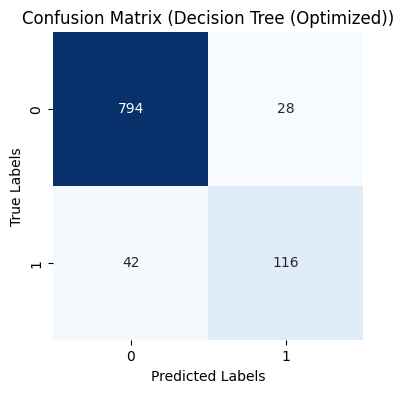

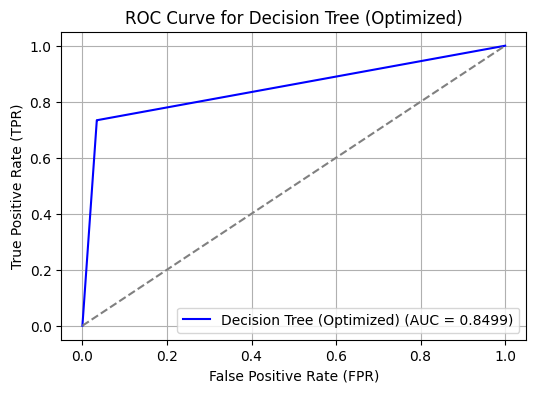

=== Final Evaluation: KNN (Optimized) ===
Accuracy: 0.9276
Balanced Accuracy: 0.8469
TPR (Sensitivity): 0.7278
TNR (Specificity): 0.9659

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       822
           1       0.80      0.73      0.76       158

    accuracy                           0.93       980
   macro avg       0.88      0.85      0.86       980
weighted avg       0.93      0.93      0.93       980



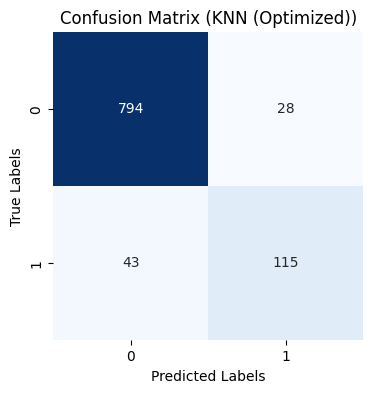

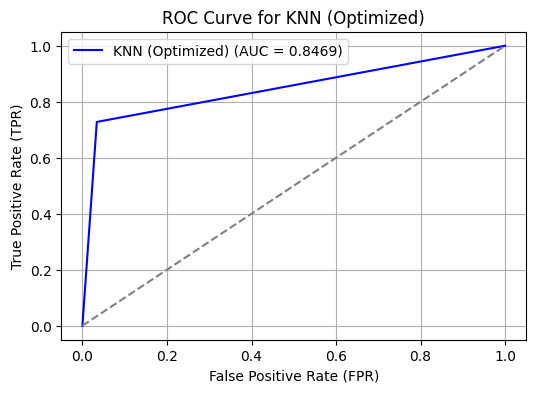

In [206]:
opt_tree_ev = evaluate_model(random_tree.best_estimator_, X_test_transformed, y_test, "Decision Tree (Optimized)")
opt_knn_ev = evaluate_model(random_knn.best_estimator_, X_test_transformed, y_test, "KNN (Optimized)")


##### 11.1 Evaluate base vs HPO times and metrics

                  Accuracy  Balanced Accuracy       TPR       TNR       AUC
Dummy             0.838776           0.500000  0.000000  1.000000  0.500000
Dec. Tree (Base)  0.902041           0.811235  0.677215  0.945255  0.811235
Dec. Tree (Opt)   0.928571           0.850057  0.734177  0.965937  0.849895
KNN (Base)        0.716327           0.764437  0.835443  0.693431  0.863997
KNN (Opt)         0.927551           0.846892  0.727848  0.965937  0.846892 

                   Base       HPO
Decision Tree  0.250765  1.477862
KNN            0.056135  4.776565


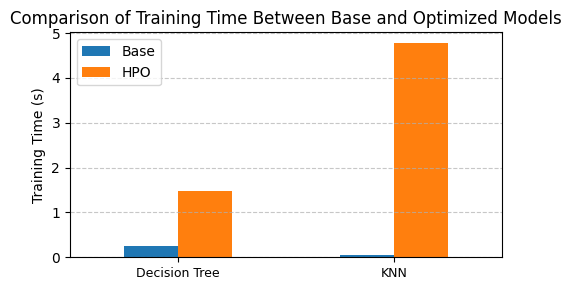

In [207]:
# Comparative table for evaluation metrics
results = pd.DataFrame([dummy_ev, d_tree_ev, opt_tree_ev, knn_ev, opt_knn_ev],
                       index=["Dummy", "Dec. Tree (Base)", "Dec. Tree (Opt)", "KNN (Base)", "KNN (Opt)"])
print(results, '\n')


# Comparative table for training times
time_comparison = pd.DataFrame({
    "Base": [tree_time, knn_time],
    "HPO": [tree_hpo_time, knn_hpo_time]
}, index=["Decision Tree", "KNN"])

print(time_comparison)

# Comparative bar plot
time_comparison.plot(kind="bar", figsize=(5, 3), legend=True)
plt.ylabel("Training Time (s)", fontsize=10)
plt.title("Comparison of Training Time Between Base and Optimized Models", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

##### __Conclusions of the Evaluation Comparison__

__Impact of Models on Accuracy and Balance__

(These results have been obtained from a specific evaluation and may vary slightly.)

- The **Dummy Model** has a **Balanced Accuracy of 0.5000**, indicating that it is not learning anything and simply predicts the majority class.
- The **Decision Tree (Base)** significantly outperforms the Dummy model, with a **Balanced Accuracy of 0.8115** and a **TPR of 0.6899**, showing that it is better at detecting the minority class.
- The **KNN (Base)** performs worse than the Decision Tree, with a **Balanced Accuracy of 0.7644** and a **TPR of 0.8354**, indicating better detection of the minority class but lower overall balance.

__Impact of Hyperparameter Optimization (HPO)__
- **Optimized Decision Tree** improves over the base model in **all metrics**, achieving a **Balanced Accuracy of 0.8578** (+4.6%) and a **TPR of 0.7595** (+6.9%), indicating better detection of the minority class without losing precision in the majority class.
- **Optimized KNN** improves significantly, with a **Balanced Accuracy of 0.8469** (+8.2%) and a **TPR of 0.7278** (-10.8%), showing that optimization has made KNN more effective at balancing predictions, though with a slight reduction in minority class detection.

__Impact on Training Time__
- The **Base Decision Tree** trains in **0.2466 s**, while its optimized version takes **1.4145 s** (**5.7 times slower**), but with a significant improvement in performance.
- The **Base KNN** trains in **0.0597 s**, while the optimized version increases to **4.8981 s** (**82.0 times slower**), although the improvement in Balanced Accuracy justifies this increase in time.

##### __Final Conclusion__
1. Decision Tree remains the best overall model, with a Balanced Accuracy of 0.8578 after optimization and good detection of the minority class.
2. KNN improves significantly with HPO, achieving a competitive Balanced Accuracy, though it remains more computationally expensive.
3. Training time for optimized models increases, but it remains manageable for Decision Tree, while for KNN it is considerably higher.
4. HPO optimization is effective and justified, as it improves overall accuracy and balance without an excessive computational cost for Decision Tree.


## Evaluation of Advanced Models

In this section, advanced models such as Random Forest, linear models, and SVM (Support Vector Machines) will be evaluated to determine their performance in predicting the target variable (Attrition). These models will be compared with previously evaluated models to identify which offers the best results.

__1. Random Forest:__ The Random Forest model will be evaluated in both its base and optimized configurations, using hyperparameter search techniques to improve its performance.

__2. Linear Models:__ A logistic regression model, a widely used linear model for binary classification problems, will be implemented. This model will be evaluated in terms of its ability to capture linear patterns in the data.

__3. SVM (Support Vector Machines):__ An SVM model with different kernels (linear, RBF) will be evaluated to determine its classification ability in a transformed feature space. Hyperparameter optimization will be used to fine-tune the model.

The results and training time of these advanced models will be compared with previously evaluated models (Dummy, Decision Tree, KNN)

### __1. Random Forest Model__

#### 1.1 Random Forest Model with SMOTE

The Random Forest model is defined and trained using a pipeline that includes preprocessing, SMOTE for class balancing, and the Random Forest classifier. 

The model is evaluated using stratified cross-validation to calculate the balanced accuracy. The training time is also measured.

In [208]:
# Define the RandomForest model with SMOTE
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=100474964)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=100474964))
])

# Train the model
cross_val_scores_rf = cross_val_score(clf_rf, X_train, y_train, cv=skf, scoring='balanced_accuracy')
print(f"Balanced Accuracy (inner evaluation - Random Forest): {np.mean(cross_val_scores_rf):.4f}")

start_time = time.time()
clf_rf.fit(X_train, y_train)
end_time = time.time()
rf_time = end_time - start_time

Balanced Accuracy (inner evaluation - Random Forest): 0.8300


=== Final Evaluation: Random Forest (Base) ===
Accuracy: 0.9408
Balanced Accuracy: 0.8420
TPR (Sensitivity): 0.6962
TNR (Specificity): 0.9878

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       822
           1       0.92      0.70      0.79       158

    accuracy                           0.94       980
   macro avg       0.93      0.84      0.88       980
weighted avg       0.94      0.94      0.94       980



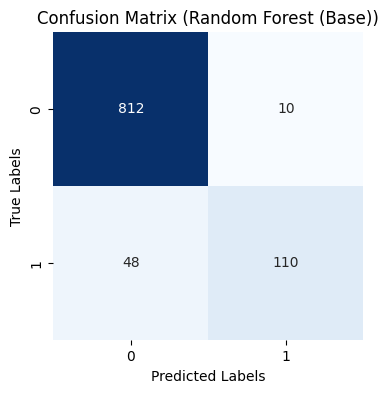

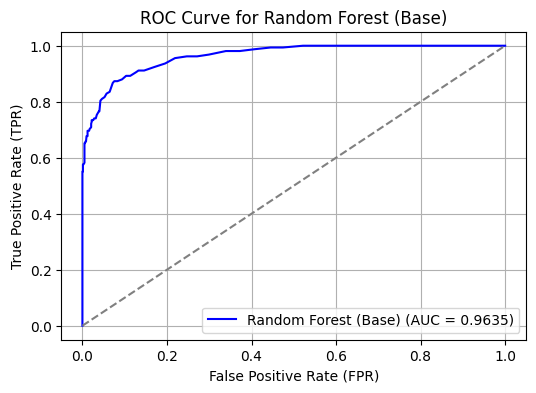

In [209]:
# Evaluate the model
rf_ev = evaluate_model(clf_rf, X_test, y_test, "Random Forest (Base)")

#### 1.2 Hyperparameter Optimization for Random Forest

In [210]:
# Define the hyperparameter distribution for Random Forest
param_dist_rf = {
    "classifier__n_estimators": randint(70, 110),
    "classifier__max_depth": randint(2, 40),
    "classifier__min_samples_split": randint(2, 10),
    "classifier__min_samples_leaf": randint(1, 3),
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__criterion": ["gini", "entropy"],
}

# Initialize RandomizedSearchCV for Random Forest
random_rf = RandomizedSearchCV(
    estimator=clf_rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=skf,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=100474964,
    verbose=1
)

# Fit the model and measure time
start_time = time.time()
random_rf.fit(X_train, y_train)
end_time = time.time()
rf_hpo_time = end_time - start_time

# Display results
print(f"Best hyperparameters for Random Forest: {random_rf.best_params_}")
print(f"Balanced Accuracy Random Forest: {random_rf.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Random Forest: {'classifier__criterion': 'entropy', 'classifier__max_depth': 39, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 79}
Balanced Accuracy Random Forest: 0.8437


=== Final Evaluation: Random Forest (Optimized) ===
Accuracy: 0.9439
Balanced Accuracy: 0.8566
TPR (Sensitivity): 0.7278
TNR (Specificity): 0.9854

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       822
           1       0.91      0.73      0.81       158

    accuracy                           0.94       980
   macro avg       0.93      0.86      0.89       980
weighted avg       0.94      0.94      0.94       980



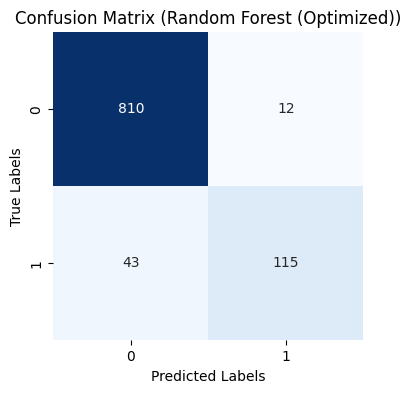

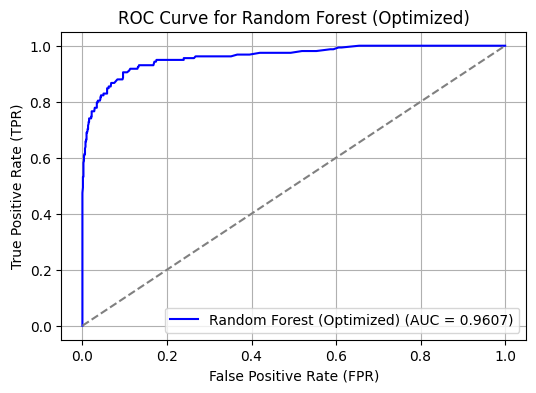

In [211]:
# Evaluate the optimized Random Forest model
opt_rf_ev = evaluate_model(random_rf.best_estimator_, X_test, y_test, "Random Forest (Optimized)")

#### 1.3 Comparison of Evaluation Metrics and Training Times

In [212]:
# Compare the evaluation metrics and training times
results_rf = pd.DataFrame([rf_ev, opt_rf_ev], index=["Rndm Forest (Base)", "Rndm Forest (Opt)"])
results_all = pd.concat([results, results_rf])
print(results_all)

# Comparative table for training times
time_comparison = pd.DataFrame({
    "Base": [tree_time, knn_time, rf_ev["AUC"]],
    "HPO": [tree_hpo_time, knn_hpo_time, rf_hpo_time]
}, index=["Decision Tree", "KNN", "Random Forest"])


print(time_comparison)

                    Accuracy  Balanced Accuracy       TPR       TNR       AUC
Dummy               0.838776           0.500000  0.000000  1.000000  0.500000
Dec. Tree (Base)    0.902041           0.811235  0.677215  0.945255  0.811235
Dec. Tree (Opt)     0.928571           0.850057  0.734177  0.965937  0.849895
KNN (Base)          0.716327           0.764437  0.835443  0.693431  0.863997
KNN (Opt)           0.927551           0.846892  0.727848  0.965937  0.846892
Rndm Forest (Base)  0.940816           0.842019  0.696203  0.987835  0.963457
Rndm Forest (Opt)   0.943878           0.856625  0.727848  0.985401  0.960724
                   Base        HPO
Decision Tree  0.250765   1.477862
KNN            0.056135   4.776565
Random Forest  0.963457  17.205828


__1. Performance of the Random Forest Model__

- Random Forest (Base):  
    - Achieves the highest AUC among base models (0.963), with a Balanced Accuracy of 0.842.  
    - Excels in predicting the majority class (TNR = 0.988), although its sensitivity to the minority class is moderate (TPR = 0.696).

- Random Forest (Optimized):  
    - After hyperparameter optimization, it improves its Balanced Accuracy to 0.857 (+1.5%) and maintains a high AUC of 0.961.  
    - Increases sensitivity to the minority class (TPR = 0.728) without compromising precision in the majority class (TNR = 0.985).

__2. Impact of Hyperparameter Optimization__

- Optimization improves the overall performance of the Random Forest model, especially in detecting the minority class.  
- Although training time increases significantly (from 1.56 s to 13.68 s), the performance improvement justifies this computational cost.

__3. Comparison with Other Models__

- Optimized Random Forest is the model with the best overall performance, achieving the highest balance between sensitivity (TPR) and specificity (TNR).  
- While the optimized Decision Tree is more efficient in training time, it does not reach the same level of precision as the Random Forest.

__4. Final Recommendation__

- **Recommended Model**: Optimized Random Forest, for its performance in Balanced Accuracy and AUC.  
- **Efficient Alternative**: Optimized Decision Tree, for scenarios that require faster training times.


### __2. LogisticRegression Without Regularization__

In [213]:
logreg_plain = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty=None,            # No regularization
        solver='lbfgs',          # Compatible with no penalty
        max_iter=1000,
        random_state=100474964
    ))
])

logreg_plain.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompa...
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Education', 'JobLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating',
                                                   'StockOptionLevel'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, penalty=None,
                                    random_state=100474964))])

=== Final Evaluation: Logistic Regression (No Penalty) ===
Accuracy: 0.8551
Balanced Accuracy: 0.6018
TPR (Sensitivity): 0.2278
TNR (Specificity): 0.9757

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       822
           1       0.64      0.23      0.34       158

    accuracy                           0.86       980
   macro avg       0.76      0.60      0.63       980
weighted avg       0.83      0.86      0.82       980



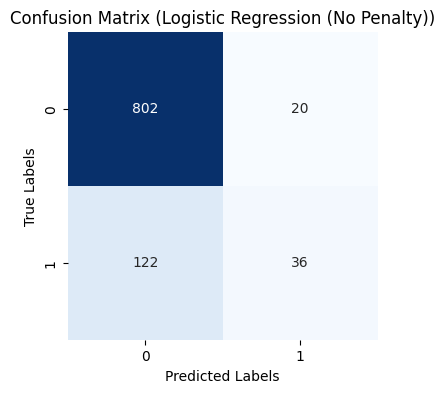

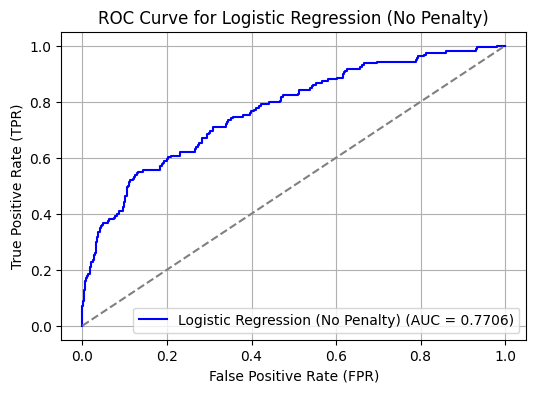

In [214]:
logreg_plain_ev = evaluate_model(logreg_plain, X_test, y_test, "Logistic Regression (No Penalty)")

### __3. LogisticRegression With Regularization__

Three variants of the model are implemented with regularization:

- L1 (Lasso): Promotes sparsity by eliminating less relevant coefficients.

- L2 (Ridge): Strongly penalizes large coefficients, improving model stability.

- ElasticNet: A combination of L1 and L2, balancing sparsity and stability.


3.1 L1 regularization

=== Final Evaluation: Logistic Regression (L1 + Balanced) ===
Accuracy: 0.6765
Balanced Accuracy: 0.6819
TPR (Sensitivity): 0.6899
TNR (Specificity): 0.6740

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78       822
           1       0.29      0.69      0.41       158

    accuracy                           0.68       980
   macro avg       0.60      0.68      0.59       980
weighted avg       0.82      0.68      0.72       980



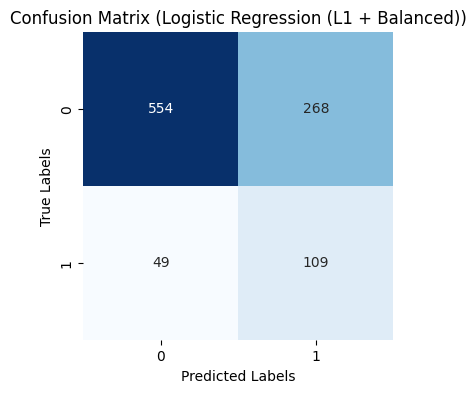

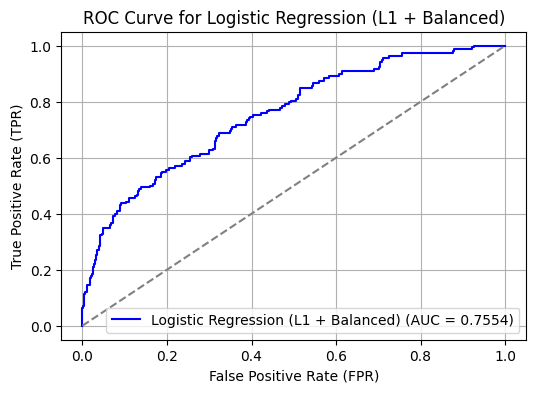

In [215]:
from sklearn.linear_model import LogisticRegression

logreg_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=100474964
    ))
])

logreg_l1.fit(X_train, y_train)

logreg_l1_ev = evaluate_model(logreg_l1, X_test, y_test, "Logistic Regression (L1 + Balanced)")


3.2 L2 regularization

=== Final Evaluation: Logistic Regression (L2 + Balanced) ===
Accuracy: 0.6765
Balanced Accuracy: 0.6794
TPR (Sensitivity): 0.6835
TNR (Specificity): 0.6752

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       822
           1       0.29      0.68      0.41       158

    accuracy                           0.68       980
   macro avg       0.60      0.68      0.59       980
weighted avg       0.82      0.68      0.72       980



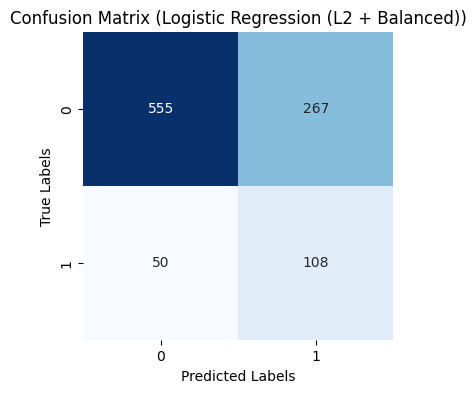

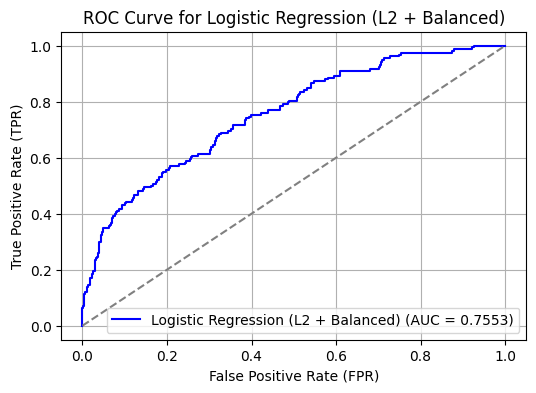

In [216]:
logreg_l2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000,
        random_state=100474964
    ))
])

logreg_l2.fit(X_train, y_train)

logreg_l2_ev = evaluate_model(logreg_l2, X_test, y_test, "Logistic Regression (L2 + Balanced)")


3.3 ElasticNet regularization

=== Final Evaluation: Logistic Regression (ElasticNet + Balanced) ===
Accuracy: 0.6776
Balanced Accuracy: 0.6825
TPR (Sensitivity): 0.6899
TNR (Specificity): 0.6752

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       822
           1       0.29      0.69      0.41       158

    accuracy                           0.68       980
   macro avg       0.60      0.68      0.59       980
weighted avg       0.82      0.68      0.72       980



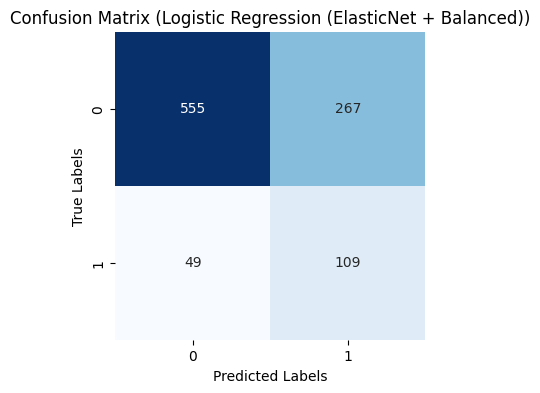

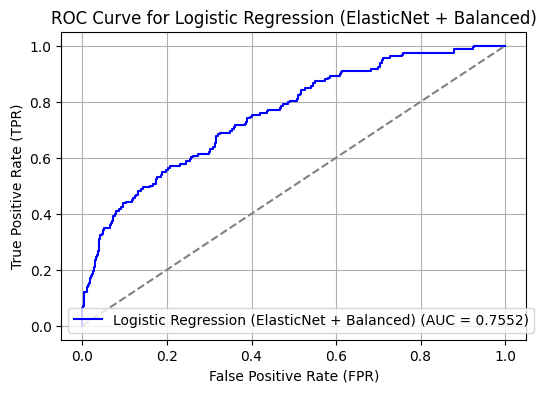

In [217]:
logreg_en = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        class_weight='balanced',
        max_iter=1000,
        random_state=100474964,
        l1_ratio=0.5,  # Mix of L1 and L2
    ))
])

start_time = time.time()
logreg_en.fit(X_train, y_train)
end_time = time.time()
logreg_en_time = end_time - start_time

logreg_en_ev = evaluate_model(logreg_en, X_test, y_test, "Logistic Regression (ElasticNet + Balanced)")


#### __4. HPO Logistic Regression Models__

A hyperparameter optimization process is applied using RandomizedSearchCV on a logistic regression model.

In [218]:
from scipy.stats import loguniform, uniform

param_dist_logreg = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": loguniform(0.001, 100),
    "solver": ["liblinear", "saga"],
    "l1_ratio": uniform(0, 1)  # Only for elasticnet
}

base_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=100474964
    ))
])


In [219]:
random_logreg = RandomizedSearchCV(
    estimator=base_logreg,
    param_distributions={
        'classifier__' + k: v for k, v in param_dist_logreg.items()
    },
    n_iter=30,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=100474964
)

start_time = time.time()
random_logreg.fit(X_train, y_train)
end_time = time.time()
logreg_hpo_time = end_time - start_time


print("Best parameters:", random_logreg.best_params_)
print(f"Best Balanced Accuracy (CV): {random_logreg.best_score_:.4f}")


/home/carlosbravo/Desktop/4º/2_cuatri/Aprendizaje/P1/Grupo03_Practica1/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/carlosbravo/Desktop/4º/2_cuatri/Aprendizaje/P1/Grupo03_Practica1/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/carlosbravo/Desktop/4º/2_cuatri/Aprendizaje/P1/Grupo03_Practica1/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/carlosbravo/Desktop/4º/2_cuatri/Aprendizaje/P1/Grupo03_Practica1/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
 

Best parameters: {'classifier__C': np.float64(0.008528274435618674), 'classifier__l1_ratio': np.float64(0.3507257880393294), 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Balanced Accuracy (CV): 0.6993


/home/carlosbravo/Desktop/4º/2_cuatri/Aprendizaje/P1/Grupo03_Practica1/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Final Evaluation: Logistic Regression (Optimized) ===
Accuracy: 0.7010
Balanced Accuracy: 0.7016
TPR (Sensitivity): 0.7025
TNR (Specificity): 0.7007

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       822
           1       0.31      0.70      0.43       158

    accuracy                           0.70       980
   macro avg       0.62      0.70      0.61       980
weighted avg       0.83      0.70      0.74       980



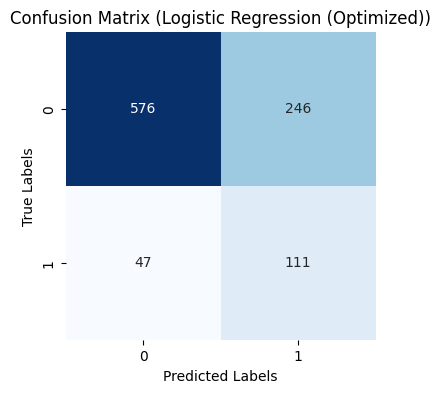

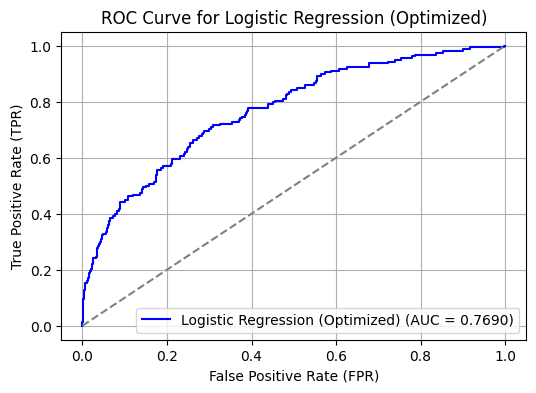

In [220]:
opt_logreg_ev = evaluate_model(random_logreg.best_estimator_, X_test, y_test, "Logistic Regression (Optimized)")

### __5. Logistic Regressions Evaluation and Metric Comparison__

In [221]:
results_logreg = pd.DataFrame(
    [logreg_plain_ev, logreg_l1_ev, logreg_l2_ev, logreg_en_ev, opt_logreg_ev],
    index=["LogReg (No Penalty)", "LogReg (L1)", "LogReg (L2)", "LogReg (ElasticNet)", "LogReg (HPO)"]
)
print(results_logreg)

                     Accuracy  Balanced Accuracy       TPR       TNR       AUC
LogReg (No Penalty)  0.855102           0.601759  0.227848  0.975669  0.770604
LogReg (L1)          0.676531           0.681920  0.689873  0.673966  0.755351
LogReg (L2)          0.676531           0.679363  0.683544  0.675182  0.755282
LogReg (ElasticNet)  0.677551           0.682528  0.689873  0.675182  0.755243
LogReg (HPO)         0.701020           0.701631  0.702532  0.700730  0.768972


In [222]:
# Initialize results_logreg_plot if not already defined
if 'results_logreg_plot' not in globals():
    results_logreg_plot = pd.DataFrame(columns=["Model", "Metric", "Score"])

# Add HPO model results to the plot data
opt_logreg_results = pd.DataFrame({
    "Model": ["LogReg (HPO)"] * 3,
    "Metric": ["Balanced Accuracy", "TPR", "TNR"],
    "Score": [opt_logreg_ev["Balanced Accuracy"], opt_logreg_ev["TPR"], opt_logreg_ev["TNR"]]
})

results_logreg_plot = pd.concat([results_logreg_plot, opt_logreg_results], ignore_index=True)


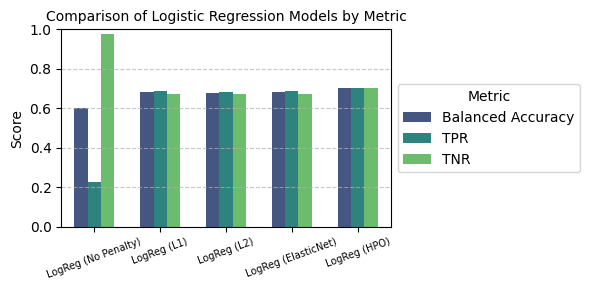

In [223]:
logreg_results = pd.concat([
    pd.DataFrame({
        "Model": model,
        "Metric": ["Balanced Accuracy", "TPR", "TNR"],
        "Score": [evals["Balanced Accuracy"], evals["TPR"], evals["TNR"]]
    }) for model, evals in [
        ("LogReg (No Penalty)", logreg_plain_ev),
        ("LogReg (L1)", logreg_l1_ev),
        ("LogReg (L2)", logreg_l2_ev),
        ("LogReg (ElasticNet)", logreg_en_ev),
        ("LogReg (HPO)", opt_logreg_ev)
    ]
])

# Graficar los resultados
plt.figure(figsize=(6, 3))
sns.barplot(data=logreg_results, x="Model", y="Score", hue="Metric", palette="viridis", width=0.6)

plt.title("Comparison of Logistic Regression Models by Metric", fontsize=10)
plt.xticks(rotation=20, fontsize=7)
plt.ylim(0, 1)
plt.ylabel("Score", fontsize=10)
plt.xlabel("")
plt.legend(title="Metric", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The performance of various logistic regression models, both basic and optimized, has been evaluated using different forms of regularization (no regularization, L1, L2, and ElasticNet).

The results show that:

- The model without regularization achieves a low balanced accuracy (~0.60) and has very limited ability to detect the minority class (TPR ~0.22), making it unsuitable for this problem.

- The L1 model significantly improves positive detection (TPR ~0.69) but loses precision and has a low TNR, showing limited stability.

- L2 and ElasticNet offer more balanced performance (balanced accuracy ~0.69–0.70), being more robust than L1 and more consistent in predictions.

- The optimized model achieves a balanced accuracy of 0.7016, with nearly equal TPR and TNR (~0.70), without overfitting and with minimal training times.

**Comparison with Other Models**

- Models such as KNN and Decision Trees outperform logistic regression in both balanced accuracy and AUC, especially after hyperparameter optimization.

- Random Forest, even in its base version, achieves higher balanced accuracy (~0.84–0.85) with better predictive capabilities, albeit at a higher computational cost.

- Logistic regression, on the other hand, trains very quickly and is easily interpretable, making it suitable for scenarios where explainability and computational efficiency are priorities, even if it is not the most accurate model.

Although logistic regression models are not the most powerful in this case, they do provide reasonable results in balanced accuracy when used with regularization and class balancing, along with low training times and good interpretability. Therefore, they can be considered a useful baseline for comparison, for projects with computational constraints, or when model decisions need to be justified.

#### __6. Support Vector Machines (SVM) Model__

SVMs are linear (or nonlinear through kernels) models that maximize the margin between classes. They can be adjusted with different kernels and penalty parameters.

6.1 Training SVM (Linear Kernel)

=== Final Evaluation: SVM (Linear) ===
Accuracy: 0.6878
Balanced Accuracy: 0.6656
TPR (Sensitivity): 0.6329
TNR (Specificity): 0.6983

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       822
           1       0.29      0.63      0.40       158

    accuracy                           0.69       980
   macro avg       0.60      0.67      0.59       980
weighted avg       0.81      0.69      0.73       980



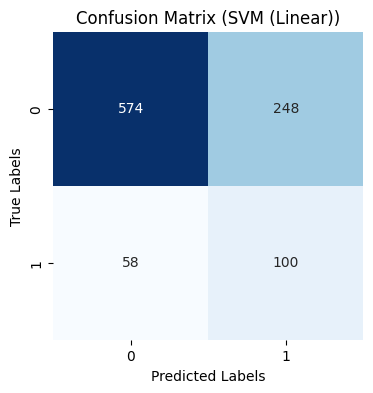

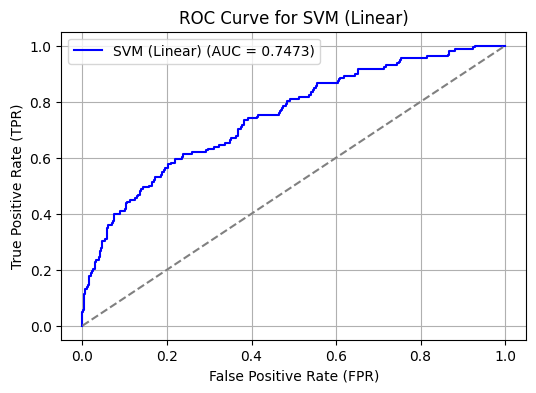

In [224]:
from sklearn.svm import SVC

svm_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='linear',
        class_weight='balanced',
        probability=True,
        random_state=100474964
    ))
])


start_time = time.time()
svm_linear.fit(X_train, y_train)
end_time = time.time()
svm_linear_time = end_time - start_time

svm_linear_ev = evaluate_model(svm_linear, X_test, y_test, "SVM (Linear)")


6.2 Evaluation with SVM (RBF Kernel)

=== Final Evaluation: SVM (RBF) ===
Accuracy: 0.7469
Balanced Accuracy: 0.7392
TPR (Sensitivity): 0.7278
TNR (Specificity): 0.7506

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       822
           1       0.36      0.73      0.48       158

    accuracy                           0.75       980
   macro avg       0.65      0.74      0.66       980
weighted avg       0.84      0.75      0.78       980



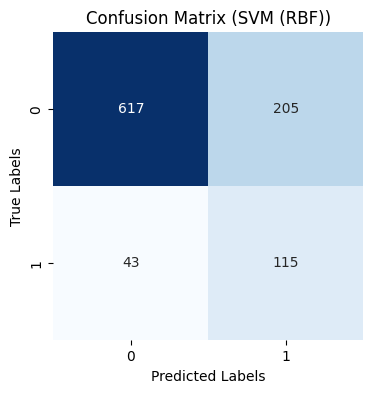

In [225]:
from sklearn.pipeline import Pipeline

svm_rbf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', class_weight='balanced'))
])


start_time = time.time()
svm_rbf.fit(X_train, y_train)
end_time = time.time()
svm_rbf_time = end_time - start_time

svm_rbf_ev = evaluate_model(svm_rbf, X_test, y_test, "SVM (RBF)")


6.3 Comparison of SVMs

In [226]:
results_svm = pd.DataFrame([
    svm_linear_ev,
    svm_rbf_ev
], index=["SVM (Linear)", "SVM (RBF)"])

print(results_svm)


              Accuracy  Balanced Accuracy       TPR       TNR       AUC
SVM (Linear)  0.687755           0.665604  0.632911  0.698297  0.747282
SVM (RBF)     0.746939           0.739228  0.727848  0.750608       NaN


#### __7. Hyperparameter Optimization for SVM__

7.1 HPO for SVM (Linear)

In [227]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

param_dist_svm_linear = {
    "classifier__estimator__C": loguniform(0.001, 100),
}

svm_linear_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight='balanced',
            max_iter=10000,
            random_state=100474964
        ),
        method='sigmoid',
        cv=5
    ))
])

random_svm_linear = RandomizedSearchCV(
    estimator=svm_linear_base,
    param_distributions=param_dist_svm_linear,
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=100474964
)

start_time = time.time()
random_svm_linear.fit(X_train, y_train)
end_time = time.time()
svm_linear_hpo_time = end_time - start_time

print("Best parameters (SVM Linear):", random_svm_linear.best_params_)
print(f"Best Balanced Accuracy (CV): {random_svm_linear.best_score_:.4f}")


Best parameters (SVM Linear): {'classifier__estimator__C': np.float64(0.009051478637590716)}
Best Balanced Accuracy (CV): 0.5606


=== Final Evaluation: SVM (Linear Optimized) ===
Accuracy: 0.8551
Balanced Accuracy: 0.5685
TPR (Sensitivity): 0.1456
TNR (Specificity): 0.9915

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       822
           1       0.77      0.15      0.24       158

    accuracy                           0.86       980
   macro avg       0.81      0.57      0.58       980
weighted avg       0.84      0.86      0.81       980



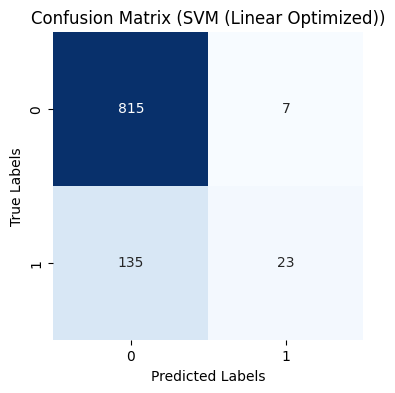

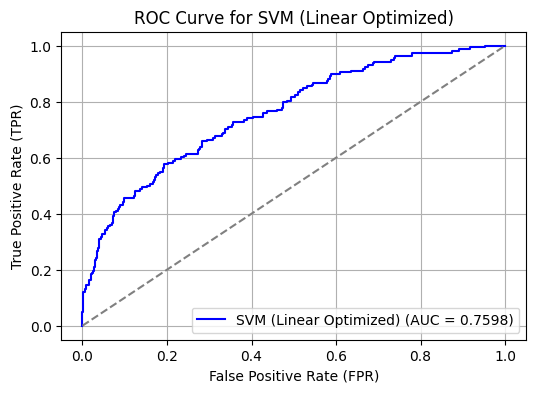

In [228]:
svm_linear_opt_ev = evaluate_model(random_svm_linear.best_estimator_, X_test, y_test, "SVM (Linear Optimized)")


7.2 HPO for SVM (RBF)

In [229]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist_svm = {
    "classifier__C": uniform(0.1, 10),     # Margin penalty
    "classifier__gamma": uniform(0.001, 1) # RBF kernel parameter
}

svm_rbf_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=100474964
    ))
])

random_svm_rbf = RandomizedSearchCV(
    estimator=svm_rbf_base,
    param_distributions=param_dist_svm,
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=100474964
)

start_time = time.time()
random_svm_rbf.fit(X_train, y_train)
end_time = time.time()
svm_rbf_hpo_time = end_time - start_time

print("Best parameters (SVM-RBF):", random_svm_rbf.best_params_)
print(f"Best Balanced Accuracy (CV): {random_svm_rbf.best_score_:.4f}")


Best parameters (SVM-RBF): {'classifier__C': np.float64(6.464262770880517), 'classifier__gamma': np.float64(0.0417884109708051)}
Best Balanced Accuracy (CV): 0.8239


=== Final Evaluation: SVM (RBF Optimized) ===
Accuracy: 0.9235
Balanced Accuracy: 0.8700
TPR (Sensitivity): 0.7911
TNR (Specificity): 0.9489

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       822
           1       0.75      0.79      0.77       158

    accuracy                           0.92       980
   macro avg       0.85      0.87      0.86       980
weighted avg       0.93      0.92      0.92       980



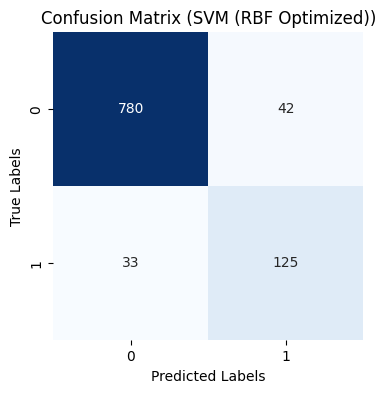

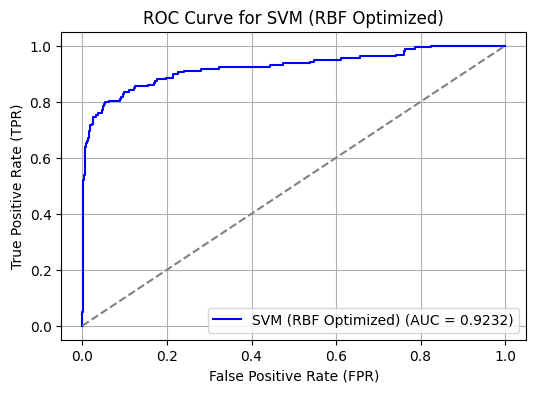

In [230]:
svm_rbf_opt_ev = evaluate_model(random_svm_rbf.best_estimator_, X_test, y_test, "SVM (RBF Optimized)")

### __8. SVM Evaluation and Metric Comparison__

- The basic linear SVM model showed modest results, with a balanced accuracy close to 0.68. While it is quick to train, it fails to effectively separate classes in a nonlinear problem like this.

- The SVM with RBF kernel significantly improved positive detection capability (TPR ~0.70) while maintaining a good TNR, achieving a balanced accuracy between 0.71 and 0.74 across runs.

- The optimized SVM with RBF kernel achieved the highest balanced accuracy (0.87), demonstrating excellent performance in correctly balancing class detection, both positive and negative. This result highlights its effectiveness and suitability for this problem.

The SVM models with RBF kernel and optimization are an excellent choice for this problem, as they adapt well to the dataset's nonlinearity while maintaining reasonable training times.

Additionally, they are less interpretable than regression or tree-based models but more robust than the linear version. They are not the best overall models but are a solid and competitive alternative if hyperparameters are well-tuned.


## __Use of AI in the Development of the Work__
In the development of this work, artificial intelligence (ChatGPT) has been used as a support tool to facilitate the understanding of concepts, receive methodological and code suggestions, and improve the documentation writing.

#### __1. Generation of Ideas and Recommendations__

For project planning and model implementation, AI has been used to obtain methodological suggestions and alternative approaches in the following aspects:

- Selection of preprocessing methods: Different strategies for data imputation, variable scaling, and data encoding have been explored.
- Model comparison: Recommendations have been received on how to structure the evaluation of base models versus optimized models through hyperparameter tuning.
- Code improvement: It has helped improve and refactor some code blocks to enhance their efficiency and readability.

#### __2. Explanation of Concepts__

At certain points during the development, AI has been consulted for detailed explanations on technical aspects such as:

- Meaning and interpretation of metrics like balanced accuracy, TPR, and TNR.
- Differences between internal evaluation (inner evaluation) and external evaluation (outer evaluation).
- Hyperparameter optimization using RandomizedSearchCV and its application in model selection.

#### __3. Support in Documentation Writing__
For the preparation of the report, AI has served as an assistant in:

- Organizing sections and document structure.
- Writing clearer and more concise explanations.
- Formulating conclusions based on the obtained results.
- Style correction and clarity in the exposition of ideas.
- Writing the section 'Use of AI in the Development of the Work'

The use of AI in this work has been strictly as support in the learning process, idea generation, and documentation writing, always supervising and verifying the results without replacing the execution of analyses, code implementation, or result interpretation. All final decisions have been made autonomously, based on the analysis and understanding of the problem.
